<a href="https://colab.research.google.com/github/fariyanalam/Projects/blob/main/PHYS152_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Supersymmetric (SUSY) and Standard Model Particle Classification using Autoencoder + Classifier


**Introduction and Overview:**

The Large Hadron Collider (LHC) is a particle accelerator that allows for the collision of two high-energy particle beams which travel close to the speed of light. Since the introduction of the LHC, there have been significant advancements in particle physics,
including the discovery of the Higgs boson. The discovery of the Higgs boson proved the theoretical models beyond the Standard Model. Supersymmetric (SUSY) is considered as an extension of the Standard Model, predicting that every particle in the Standard Model has a partner particle with a different spin. Given the distinct spin values of
fermions and bosons, physicists can analyze collision data to identify differences in decay patterns and interaction properties.


**Data Loading & Exploration:**

First, we will import the dataset from Kaggle and visualize the data distributions after scaling. The purpose of this step is to get an idea of skewness, outliers, or abnormalities. We will choose a "random feature X" to check for normal distribution and skewness.

100%|██████████| 762M/762M [00:09<00:00, 88.2MB/s]

Extracting files...


   label  lepton_pT  lepton_eta  lepton_phi  missing_energy_magnitude  \
0    0.0   0.707258    0.613159   -0.763354                  1.010814   
1    0.0   0.493745   -1.745581   -0.640968                  0.576161   
2    1.0   1.305413    0.283820   -1.149154                  0.507217   
3    1.0   0.809715   -0.358303   -0.497172                  0.787675   
4    0.0   0.912852    1.797455   -1.360165                  0.496723   

   missing_energy_phi   jet1_pT  jet1_eta  jet1_phi   jet2_pT  jet2_eta  \
0            1.672101  1.544314  0.342641  0.286944  0.514347 -0.008000   
1           -0.514477 -0.629788  0.585841  0.874038  0.879419 -0.221701   
2           -0.194161  1.313993  0.659832  0.619593  0.534922 -0.320298   
3            0.027419  1.201305  0.790556 -0.861923  0.740287  0.890525   
4            1.199644  0.627462  1.206452 -1.362983  0.033791  1.509121   

   jet2_phi   jet3_pT  jet3_eta  jet3_phi   jet4_pT  jet4_eta  jet4_phi  \
0  0.832800  0.646217  0.688581  1.

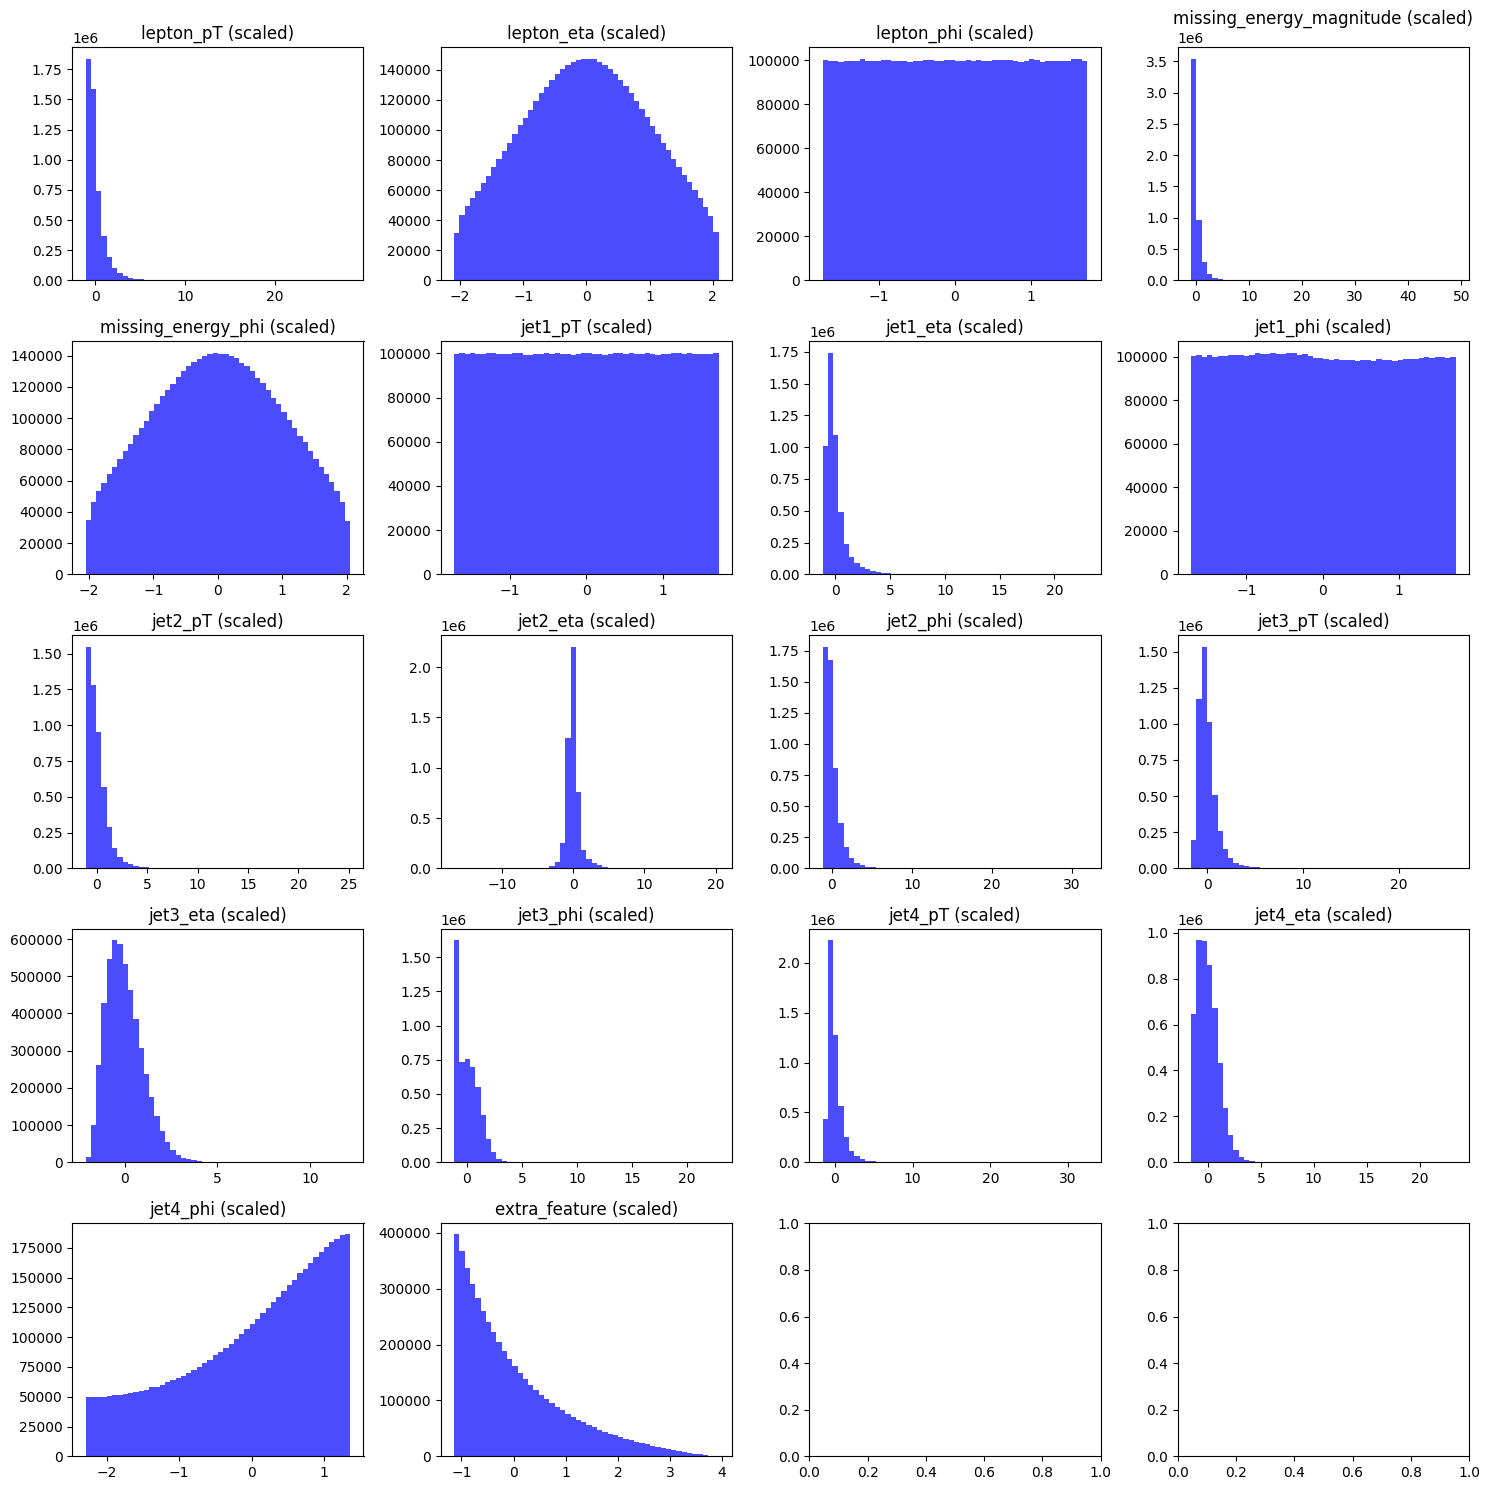

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub

# Downloading the latest version of the dataset
path = kagglehub.dataset_download("janus137/supersymmetry-dataset")
dataset_path = "/root/.cache/kagglehub/datasets/janus137/supersymmetry-dataset/versions/1/supersymmetry_dataset.csv"

data = pd.read_csv(dataset_path, header=0)

# Assigning columns
data.columns = [
    'label',
    'lepton_pT', 'lepton_eta', 'lepton_phi',
    'missing_energy_magnitude', 'missing_energy_phi',
    'jet1_pT', 'jet1_eta', 'jet1_phi',
    'jet2_pT', 'jet2_eta', 'jet2_phi',
    'jet3_pT', 'jet3_eta', 'jet3_phi',
    'jet4_pT', 'jet4_eta', 'jet4_phi',
    'extra_feature'
]

print(data.head())
print(data.describe())
print(data.info())

# Define features (X) and labels (y)
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Visualizing the distributions of all scaled features
fig, axs = plt.subplots(5, 4, figsize=(15, 15))
axs = axs.flatten()

for i, col in enumerate(X_train_scaled_df.columns):
    axs[i].hist(X_train_scaled_df[col], bins=50, color='blue', alpha=0.7)
    axs[i].set_title(f'{col} (scaled)')

plt.tight_layout()
plt.show()

**Binary Classifier:**

[Built classifier using compressed features]

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle  # For saving dictionaries

# Define model
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Convert data to tensors
x_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
xy_train = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(X_train) / 5), shuffle=True)

# Dictionaries to store losses
train_losses_dict = {}
test_losses_dict = {}

# Training loop for different learning rates
for lr in [0.02, 0.05, 0.1]:
    print(f"Learning Rate: {lr}")

    # Initialize model, loss function, and optimizer
    input_dim = X_train.shape[1]
    net = BinaryClassifier(input_dim)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    net.train()
    train_losses = []
    test_losses = []

    for epoch in range(10):
        start_time = time.time()

        for x_batch, y_batch in loader:
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())  # Store final batch loss for this epoch

        net.eval()
        with torch.no_grad():
            y_pred_test = net(x_test_tensor)
            test_loss = loss_fn(y_pred_test, y_test_tensor)
            test_losses.append(test_loss.item())

        end_time = time.time()
        print(f"Epoch {epoch+1:2d} | Time: {end_time - start_time:.1f}s | Train Loss: {loss.item():.1e} | Test Loss: {test_loss.item():.1e}")

    train_losses_dict[lr] = train_losses
    test_losses_dict[lr] = test_losses

with open("loss_data.pkl", "wb") as f:
    pickle.dump({"train": train_losses_dict, "test": test_losses_dict}, f)

print("Loss values saved to loss_data.pkl")
torch.save(net.state_dict(), "binary_classifier.pth")

Learning Rate: 0.02
Epoch  1 | Time: 57.2s | Train Loss: 5.7e-01 | Test Loss: 5.3e-01
Epoch  2 | Time: 47.7s | Train Loss: 4.7e-01 | Test Loss: 4.7e-01
Epoch  3 | Time: 43.7s | Train Loss: 4.7e-01 | Test Loss: 4.7e-01
Epoch  4 | Time: 44.1s | Train Loss: 4.6e-01 | Test Loss: 4.6e-01
Epoch  5 | Time: 48.6s | Train Loss: 4.5e-01 | Test Loss: 4.5e-01
Epoch  6 | Time: 45.5s | Train Loss: 4.5e-01 | Test Loss: 4.5e-01
Epoch  7 | Time: 45.4s | Train Loss: 4.5e-01 | Test Loss: 4.5e-01
Epoch  8 | Time: 45.4s | Train Loss: 4.5e-01 | Test Loss: 4.4e-01
Epoch  9 | Time: 43.9s | Train Loss: 4.5e-01 | Test Loss: 4.4e-01
Epoch 10 | Time: 44.6s | Train Loss: 4.4e-01 | Test Loss: 4.4e-01
Learning Rate: 0.05
Epoch  1 | Time: 45.6s | Train Loss: 5.6e-01 | Test Loss: 5.5e-01
Epoch  2 | Time: 44.0s | Train Loss: 4.7e-01 | Test Loss: 4.9e-01
Epoch  3 | Time: 45.9s | Train Loss: 4.7e-01 | Test Loss: 4.6e-01
Epoch  4 | Time: 43.7s | Train Loss: 4.6e-01 | Test Loss: 4.6e-01
Epoch  5 | Time: 46.3s | Train Loss:

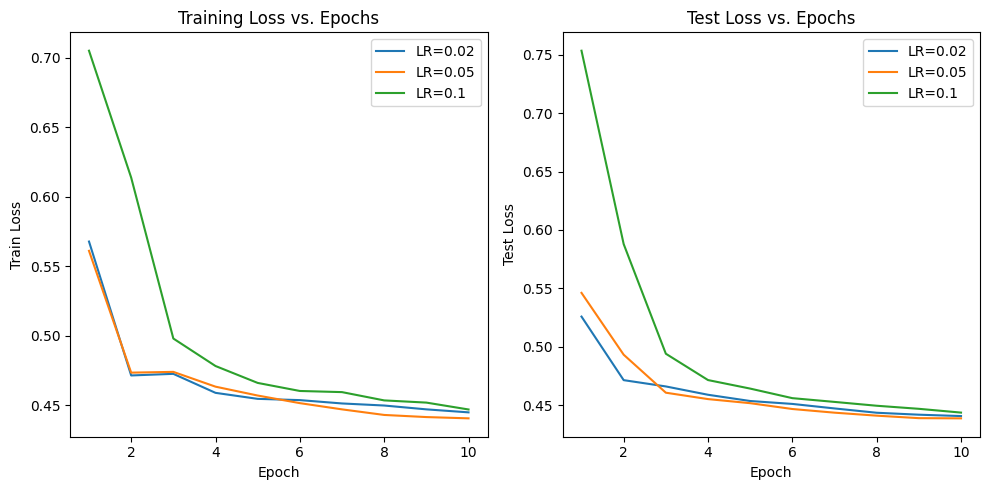

In [9]:
import pickle
import matplotlib.pyplot as plt

with open("loss_data.pkl", "rb") as f:
    loss_data = pickle.load(f)

train_losses_dict = loss_data["train"]
test_losses_dict = loss_data["test"]

plt.figure(figsize=(10, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
for lr, losses in train_losses_dict.items():
    plt.plot(range(1, 11), losses, label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()

# Plot Test Loss
plt.subplot(1, 2, 2)
for lr, losses_test in test_losses_dict.items():
    plt.plot(range(1, 11), losses_test, label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss vs. Epochs")
plt.legend()

plt.tight_layout()
plt.show()

**Autoencoder for Feature Extraction:**

Our next goal is to compress the features from the last step into a lower-dimension representation, which we'll feed into the binary classifier in the next step. The purpose of this step is to identify key patterns in the data and to reduce the noise (if any) in our dataset.

**Conclusion:**

[Summarize findings and potential improvements]